In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#### Merge the graph data as one dataframe

In [2]:
# Specify the directory of graph data
graph_features_dir = "/home/soroushm/Documents/ML-TRP-Parser_workframe/dataframes/graph_features"

# Save the path of every graph data
file_path_list = []
for root, dirs, files in os.walk(graph_features_dir):
    for filename in files:
        if filename.endswith("_features.csv"):
            file_path = os.path.join(root, filename)
            file_path_list.append(file_path)

In [3]:
# Read each CSV into a dataframe and store them in a list
df_list = [pd.read_csv(path) for path in file_path_list]
# Concatenate all dataframes together
df = pd.concat(df_list, ignore_index=True)
# Save the merged dataframe to a new CSV
df.to_csv('../data/merged_features.csv', index=False)

In [4]:
# Load merged the dataframe
df = pd.read_csv("../data/merged_features.csv", dtype={"ct": str})
df

,peak_heights,left_thresholds,right_thresholds,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,peak_x,ct,window_avg,window_len,label
0,0.365921,0.001922,0.012824,0.015101,0,25,2.172749,0.358371,5.416013,7.588763,8,4.5,36.62,44,1
1,0.523539,0.004752,0.000118,0.223897,25,70,28.663679,0.411591,34.825438,63.489117,46,4.5,36.62,44,1
2,0.538118,0.001839,0.002038,0.064424,25,105,13.041878,0.505906,83.729430,96.771307,90,4.5,36.62,44,1
3,0.949496,0.002526,0.002526,0.669662,25,227,33.909553,0.614664,115.045223,148.954777,133,4.5,36.62,44,1
4,0.314012,0.000661,0.008141,0.000661,166,182,0.540603,0.313682,166.500000,167.040603,168,4.5,36.62,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20480,0.421816,0.029708,0.041086,0.145470,9,49,10.381330,0.349081,14.243943,24.625273,20,4.2,36.80,26,0
20481,0.567528,0.004890,0.008648,0.372908,49,116,16.810540,0.381074,86.325183,103.135723,96,4.2,36.80,26,1
20482,0.415756,0.008918,0.001332,0.167968,116,171,14.505931,0.331772,126.481126,140.987057,136,4.2,36.80,26,0
20483,0.317376,0.000292,0.013720,0.027386,145,171,4.048251,0.303683,149.949781,153.998032,154,4.2,36.80,26,1


#### Check the features and prepare the train and test datasets

In [5]:
# Check the label value counts
df["label"].value_counts()

1    14247
0     6238
Name: label, dtype: int64

In [6]:
# Save the labels to a list and drop the column from df
labels = df["label"].tolist()
df.drop(["label"], axis=1, inplace=True)

In [7]:
# Either one hot encode the 'ct' or remove it

df.drop(["ct"], axis=1, inplace=True) # Remove
# df = pd.get_dummies(df, columns=['ct'], drop_first=True) # One-Hot Encode

In [8]:
# Normalize the widths relative to window_len
df["widths"] = df["widths"] / df["window_len"]

# Normalize ips and bases columns based on the difference with peak_x position relative to window_len
for column in ["left_ips", "right_ips", "left_bases", "right_bases"]:
    df[column] = (df["peak_x"] - df[column]) / df["window_len"]

df

,peak_heights,left_thresholds,right_thresholds,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,peak_x,window_avg,window_len
0,0.365921,0.001922,0.012824,0.015101,0.181818,-0.386364,0.049381,0.358371,0.058727,0.009346,8,36.62,44
1,0.523539,0.004752,0.000118,0.223897,0.477273,-0.545455,0.651447,0.411591,0.253967,-0.397480,46,36.62,44
2,0.538118,0.001839,0.002038,0.064424,1.477273,-0.340909,0.296406,0.505906,0.142513,-0.153893,90,36.62,44
3,0.949496,0.002526,0.002526,0.669662,2.454545,-2.136364,0.770672,0.614664,0.408063,-0.362609,133,36.62,44
4,0.314012,0.000661,0.008141,0.000661,0.045455,-0.318182,0.012286,0.313682,0.034091,0.021804,168,36.62,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20480,0.421816,0.029708,0.041086,0.145470,0.423077,-1.115385,0.399282,0.349081,0.221387,-0.177895,20,36.80,26
20481,0.567528,0.004890,0.008648,0.372908,1.807692,-0.769231,0.646559,0.381074,0.372108,-0.274451,96,36.80,26
20482,0.415756,0.008918,0.001332,0.167968,0.769231,-1.346154,0.557920,0.331772,0.366111,-0.191810,136,36.80,26
20483,0.317376,0.000292,0.013720,0.027386,0.346154,-0.653846,0.155702,0.303683,0.155778,0.000076,154,36.80,26


In [9]:
# Drop peak_x as not needed anymore
df.drop(["peak_x"], axis=1, inplace=True)
df

,peak_heights,left_thresholds,right_thresholds,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,window_avg,window_len
0,0.365921,0.001922,0.012824,0.015101,0.181818,-0.386364,0.049381,0.358371,0.058727,0.009346,36.62,44
1,0.523539,0.004752,0.000118,0.223897,0.477273,-0.545455,0.651447,0.411591,0.253967,-0.397480,36.62,44
2,0.538118,0.001839,0.002038,0.064424,1.477273,-0.340909,0.296406,0.505906,0.142513,-0.153893,36.62,44
3,0.949496,0.002526,0.002526,0.669662,2.454545,-2.136364,0.770672,0.614664,0.408063,-0.362609,36.62,44
4,0.314012,0.000661,0.008141,0.000661,0.045455,-0.318182,0.012286,0.313682,0.034091,0.021804,36.62,44
...,...,...,...,...,...,...,...,...,...,...,...,...
20480,0.421816,0.029708,0.041086,0.145470,0.423077,-1.115385,0.399282,0.349081,0.221387,-0.177895,36.80,26
20481,0.567528,0.004890,0.008648,0.372908,1.807692,-0.769231,0.646559,0.381074,0.372108,-0.274451,36.80,26
20482,0.415756,0.008918,0.001332,0.167968,0.769231,-1.346154,0.557920,0.331772,0.366111,-0.191810,36.80,26
20483,0.317376,0.000292,0.013720,0.027386,0.346154,-0.653846,0.155702,0.303683,0.155778,0.000076,36.80,26


In [10]:
# Divide the features and targets train and test with 0.8, 0.2 proportion
X = df  # Features
y = labels[:]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
# Standardize the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Perform a grid search for hyperparameter tuning of Logistic Regression

In [ ]:
# # Define the hyperparameter grid
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'fit_intercept': [True, False],
#     'class_weight': [None, 'balanced']
# }
#
# # Create the logistic regression model
# logreg = LogisticRegression(max_iter=5000)
#
# # Create the grid search object
# grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
#
# # Fit the grid search object to the data
# grid_search.fit(X_train, y_train)
#
# # Print the best parameters
# print("Best parameters:", grid_search.best_params_)

#### Create Logistic Regression model

In [12]:
model = LogisticRegression(max_iter=5000, C=1000, class_weight=None, fit_intercept=True, penalty='l2', solver='newton-cg')  # Using a high max_iter in case default doesn't converge
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

Logistic Regression Accuracy: 76.74%


#### Create Random Forest Classifier Model

In [13]:
model = RandomForestClassifier(n_estimators=100)  # You can adjust parameters like n_estimators
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")

Random Forest Classifier Accuracy: 82.52%


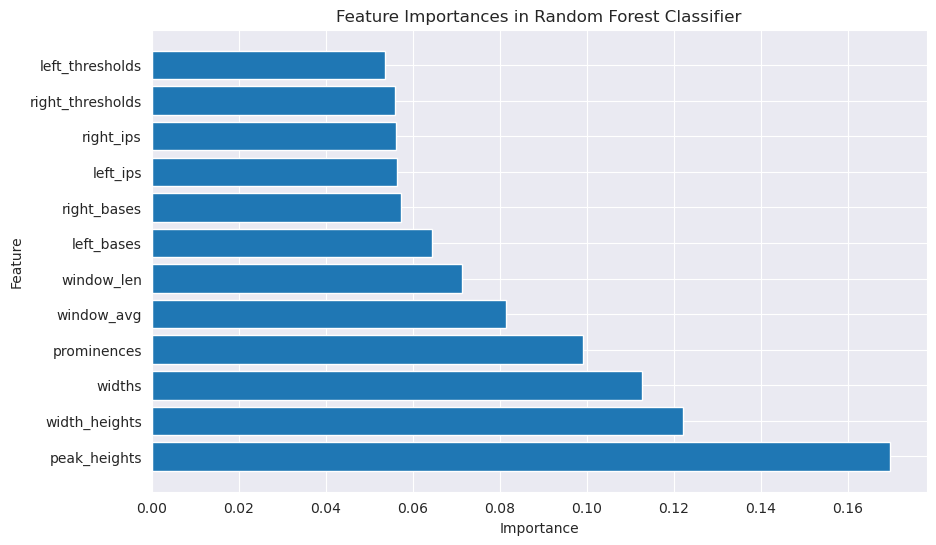

In [14]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': df.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.show()